In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob

In [2]:
#read in metrics
metrics = pd.read_csv('<path/to/your/Rosetta_metrics_for_all_designs.sc>',sep='\s+')
#rename column to remove final _0001 inserted by scoring xml
metrics['description'] = metrics['description'].map(lambda x: '_'.join(x.split('_')[:-1]))

#read in lddt scores
lddt_scores = pd.read_csv('<path/to/your/DeepAccNet_metrics_for_all_designs.sc>',sep=', ')

#read in sequences
seqs = pd.read_csv('<path/to/your/designs.seq>',names=['binder_seq','target_seq','name'],sep=' ')

#merge into signle df
scores = metrics.merge(lddt_scores,left_on='description',right_on='name',how='inner')
scores = scores.merge(seqs,on='name',how='inner')

#calculate delta_sap scores
scores.insert(len(scores.columns),'delta_sap_binder',scores['sap_score'] - scores['binder_blocked_sap'])
scores.insert(len(scores.columns),'delta_sap_target',scores['sap_score_target'] - scores['target_blocked_sap'])

#calculate binder lengths
scores.insert(len(scores.columns),'length',scores['binder_seq'].map(lambda x: len(x)))

len(scores)

/home/wlwhite/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


869037

In [3]:
scores.columns

Index(['SCORE:', 'total_score', 'binder_blocked_sap',
       'contact_molec_sq5_ap_target', 'contact_molec_sq5_apap_target',
       'contact_molecular_surface_ap_target',
       'contact_molecular_surface_apap_target', 'contact_patch', 'ddg',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_sol',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
       'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl', 'lk_ball_iso',
       'mismatch_probability', 'omega', 'p_aa_pp', 'pro_close', 'rama_prepro',
       'ref', 'sap_score', 'sap_score_target', 'score_per_res',
       'target_blocked_sap', 'description', 'name', 'global_lddt',
       'interface_lddt', 'binder_lddt', 'binder_seq', 'target_seq',
       'delta_sap_binder', 'delta_sap_target', 'length'],
      dtype='object')

In [4]:
#format:
#score_name: [cutoff, higher_better]
terms_and_cuts = {
    'ddg':                           [-35,  False], #recommended: -40 or 50%, whichever has more
    'score_per_res' :                [-2.4, False], #recommended: no filter or -2.4
    'mismatch_probability':          [0.1,  False], #recommended: 0.1
    #'contact_molecular_surface':     [520,   True], #recommended: 450
    'contact_patch':                 [195,   True], #recommended: max out
    'contact_molec_sq5_apap_target': [2700,  True], #recommended: max out
    'delta_sap_target':              [8.8,  True], #recommended: max out
    'delta_sap_binder':              [16,    True], #recommended: between 12 and 23 (but maxing out here)
    'binder_blocked_sap':            [15.75,   False], #recommended: 15
    'binder_lddt':                   [0.89,  True], #recommended top 50%
    'interface_lddt':                [0.71,  True], #recommended top 50%
    'length':                        [57,   False]  #should be less than or equal to 57 to fit in tags on a chip order
}

filtered = scores.copy()
filter_info = []
for term in terms_and_cuts:
    
    if terms_and_cuts[term][1]: #if higher better
        pass_rate = np.mean(scores[term] >= terms_and_cuts[term][0])
        filtered = filtered[filtered[term] >= terms_and_cuts[term][0]]
    else: #lower better
        pass_rate = np.mean(scores[term] <= terms_and_cuts[term][0])
        filtered = filtered[filtered[term] <= terms_and_cuts[term][0]]
        
    filter_info.append([term,terms_and_cuts[term][0],pass_rate])
    
print('Pass rate: {}\tNum Passes: {}'.format(len(filtered)/len(scores),len(filtered)))
filter_info = pd.DataFrame(filter_info,columns=['filter','cut','pass rate'])
filter_info

Pass rate: 0.011985680701742274	Num Passes: 10416


,filter,cut,pass rate
0,ddg,-35.00,0.517643
1,score_per_res,-2.40,0.605945
2,mismatch_probability,0.10,0.872925
3,contact_patch,195.00,0.521644
4,contact_molec_sq5_apap_target,2700.00,0.542664
5,delta_sap_target,8.80,0.510750
6,delta_sap_binder,16.00,0.531049
7,binder_blocked_sap,15.75,0.333553
8,binder_lddt,0.89,0.508037
9,interface_lddt,0.71,0.499821


In [5]:
print(np.prod(filter_info['pass rate']))

0.0017020142752475502


In [6]:
filtered = filtered.sort_values(by='score_per_res',ascending=True).drop_duplicates('binder_seq')
print(len(filtered))

10052


/home/wlwhite/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


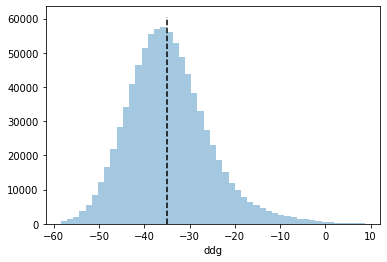

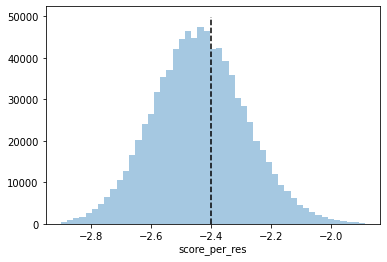

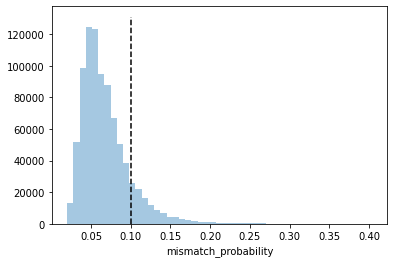

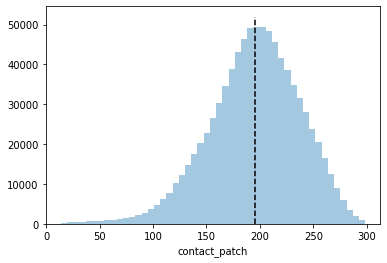

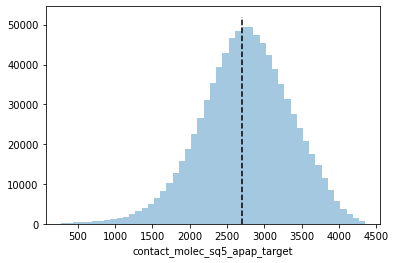

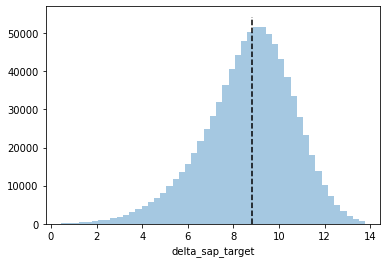

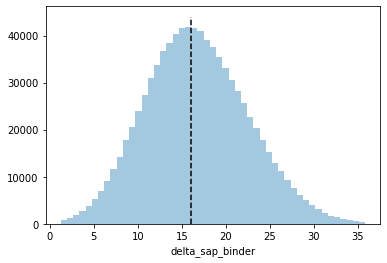

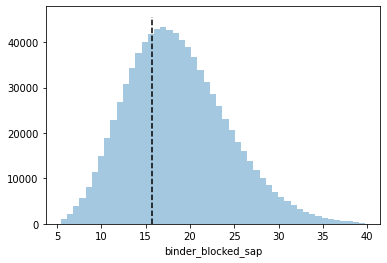

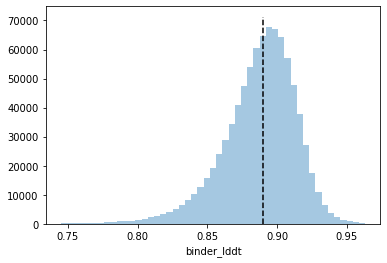

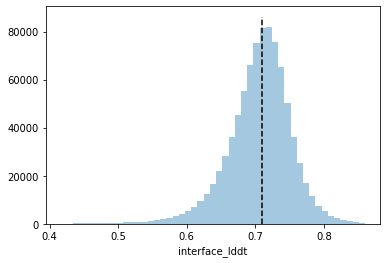

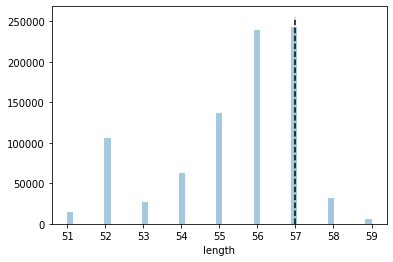

In [7]:
for term in terms_and_cuts:
    plt.figure()
    
    vals = scores[term]
    vals = vals[~np.isnan(vals)]
    bins = np.linspace(np.quantile(vals,0.001),np.quantile(vals,0.999),50)
        
    sns.distplot(vals,kde=False,bins=bins)
    plt.plot([terms_and_cuts[term][0]]*2,plt.ylim(),'k--')

<AxesSubplot:>

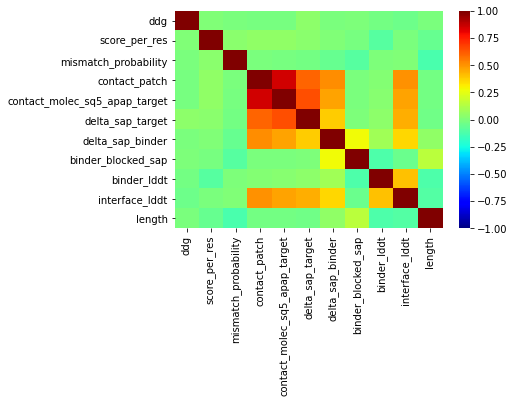

In [8]:
corr = scores[terms_and_cuts.keys()].corr()
sns.heatmap(corr,vmin=-1,vmax=1,cmap='jet')

<AxesSubplot:xlabel='length'>

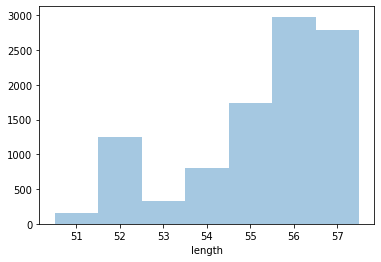

In [9]:
sns.distplot(filtered['length'],kde=False,bins=np.linspace(50.5,57.5,8))

In [10]:
filtered.to_csv('<desired/path/to>/selected_designs_with_metrics.csv')